# Projet ST 10x (Visium) — modèle 5XFAD (WT / 5XFAD / Vehicle / hNSC)

**Objectif.** Mettre en place un pipeline reproductible de spatial transcriptomics (Visium 10x) :
- charger toutes les coupes (`Sample_*`) avec leurs images/coordonnées,
- faire un contrôle qualité (QC) **adaptatif par sample**,
- intégrer et visualiser (UMAP/Leiden),
- préparer la suite (cartes de marqueurs, analyses ciblées).

**Vocabulaire.**
- **condition** : groupe biologique (WT, 5XFAD, Vehicle, hNSC).
- **replicate** : souris (réplicat biologique).
- **section** : coupe de la même souris (souvent 2 sections).
- **sample** : 1 coupe Visium (zone A/B/C/D d’un slide S2/S3/S4/S5).
- **GSM** : identifiant GEO du sample.

**Structure attendue.**
`./brain/data/<condition>/<replicate>/Sample_3792-FM-Sx-Y/{filtered_feature_bc_matrix, spatial}`

**Pourquoi plusieurs `Sample_*` ?**
Chaque `Sample_*` = **une coupe** déposée sur **une zone de capture** du slide. Les réplicats ont souvent **2 sections** pour couvrir plus de tissu/régions.


## Étape 1 — Découverte des samples (sans chargement)
On scanne l’arborescence pour **lister les `Sample_*`** qui contiennent les dossiers Visium attendus :
- `filtered_feature_bc_matrix/` (compte gènes/UMIs au format MTX),
- `spatial/` (images H&E, positions, scalefactors).

**But :** obtenir une table `samples_df` propre avec `condition / replicate / sample_name / gsm / sample_path`.
Cette table sert de **source de vérité** pour tous les chargements suivants.


In [1]:
# --- Prerequisites ---
# If needed (one time):
# !pip install scanpy==1.9.8 anndata==0.10.9 matplotlib==3.8.4 numpy pandas


In [1]:
# ÉTAPE 1 — imports + versions + setup figures (robuste)
from pathlib import Path
import numpy as np, pandas as pd
import scanpy as sc

# Versions (utile pour diagnostiquer)
try:
    import IPython
    print("IPython:", IPython.__version__)
except Exception as e:
    print("IPython non dispo ou autre :", e)
print("Scanpy :", sc.__version__)

# Verbosité
sc.settings.verbosity = 2

# Setup figures sans dépendre d'IPython.display.set_matplotlib_formats
import matplotlib as mpl
mpl.rcParams["figure.dpi"] = 120
mpl.rcParams["figure.figsize"] = (5, 4)

# On tente scanpy, mais on neutralise le format IPython pour éviter l'appel fautif
try:
    sc.set_figure_params(figsize=(5, 4), dpi=120, ipython_format=None)
except Exception as e:
    print("Skip sc.set_figure_params (ok) ->", e)

print("Figure params OK.")


IPython: 9.0.2
Scanpy : 1.11.0
Skip sc.set_figure_params (ok) -> module 'IPython.display' has no attribute 'set_matplotlib_formats'
Figure params OK.


In [2]:
# ÉTAPE 2 — Détection racine des données
if Path("./../data").exists():
    DATA_ROOT = Path("./../data")
else:
    raise FileNotFoundError("Impossible de trouver ./brain ou ./brain/data")

print("DATA_ROOT ->", DATA_ROOT.resolve())


DATA_ROOT -> /data/home/aboussif/work/brain/data


In [3]:
# ÉTAPE 3 — découverte des échantillons (aucun chargement Scanpy pour l'instant)
import re
import pandas as pd


assert 'DATA_ROOT' in globals(), "Définis d'abord DATA_ROOT (./brain/data ou ./brain)."

def discover_samples(root: Path) -> pd.DataFrame:
    rows = []
    # Parcourt tous les dossiers 'Sample_*' contenant bien les sous-dossiers 10x attendus
    for sdir in root.rglob("Sample_*"):
        if not sdir.is_dir():
            continue
        if not (sdir / "filtered_feature_bc_matrix").exists():
            continue
        if not (sdir / "spatial").exists():
            continue

        sample_name = sdir.name
        # …/<condition>/<replicate>/Sample_*
        condition = sdir.parent.parent.name  # ex: hNSC, 5XFAD, WT, Vehicle
        replicate = sdir.parent.name         # ex: replicate1, replicate2, ...

        # Essaie de retrouver le tarball voisin pour extraire le GSM
        gsm, tarball = None, None
        for t in sdir.parent.glob(f"GSM*_{sample_name}.tar.gz"):
            tarball = t
            m = re.match(r'^(GSM\d+)_', t.name)
            if m:
                gsm = m.group(1)
            break

        rows.append({
            "sample_name": sample_name,
            "condition": condition,
            "replicate": replicate,
            "gsm": gsm,
            "sample_path": str(sdir),
            "tarball": str(tarball) if tarball else None,
        })
    return pd.DataFrame(rows).sort_values(["condition","replicate","sample_name"])

samples_df = discover_samples(DATA_ROOT)

print("Total samples found:", len(samples_df))
display(samples_df.head(12))

print("\nBy condition:")
display(samples_df.groupby("condition").size())

print("\nBy condition & replicate:")
display(samples_df.groupby(["condition","replicate"]).size())


Total samples found: 14


sample_name condition   replicate         gsm  \
10  Sample_3792-FM-S2-A     5XFAD  replicate1  GSM6380080   
11  Sample_3792-FM-S2-B     5XFAD  replicate1  GSM6380081   
13  Sample_3792-FM-S5-A     5XFAD  replicate2  GSM6380092   
12  Sample_3792-FM-S5-B     5XFAD  replicate2  GSM6380093   
0   Sample_3792-FM-S3-A   Vehicle  replicate1  GSM6380084   
1   Sample_3792-FM-S3-B   Vehicle  replicate1  GSM6380085   
3   Sample_3792-FM-S2-C        WT  replicate1  GSM6380082   
2   Sample_3792-FM-S2-D        WT  replicate1  GSM6380083   
6   Sample_3792-FM-S3-C      hNSC  replicate1  GSM6380086   
7   Sample_3792-FM-S3-D      hNSC  replicate1  GSM6380087   
9   Sample_3792-FM-S4-A      hNSC  replicate2  GSM6380088   
8   Sample_3792-FM-S4-B      hNSC  replicate2  GSM6380089   

                                       sample_path  \
10    ../data/5XFAD/replicate1/Sample_3792-FM-S2-A   
11    ../data/5XFAD/replicate1/Sample_3792-FM-S2-B   
13    ../data/5XFAD/replicate2/Sample_3792-FM-S5-A   
12    ../data/5XFAD/replicate2/Sample_3792-FM-S5-B   
0   ../data/Vehicle/replicate1/Sample_3792-FM-S3-A   
1   ../data/Vehicle/replicate1/Sample_3792-FM-S3-B   
3        ../data/WT/replicate1/Sample_3792-FM-S2-C   
2        ../data/WT/replicate1/Sample_3792-FM-S2-D   
6      ../data/hNSC/replicate1/Sample_3792-FM-S3-C   
7      ../data/hNSC/replicate1/Sample_3792-FM-S3-D   
9      ../data/hNSC/replicate2/Sample_3792-FM-S4-A   
8      ../data/hNSC/replicate2/Sample_3792-FM-S4-B   

                                              tarball  
10  ../data/5XFAD/replicate1/GSM6380080_Sample_379...  
11  ../data/5XFAD/replicate1/GSM6380081_Sample_379...  
13  ../data/5XFAD/replicate2/GSM6380092_Sample_379...  
12  ../data/5XFAD/replicate2/GSM6380093_Sample_379...  
0   ../data/Vehicle/replicate1/GSM6380084_Sample_3...  
1   ../data/Vehicle/replicate1/GSM6380085_Sample_3...  
3   ../data/WT/replicate1/GSM6380082_Sample_3792-F...  
2   ../data/WT/replicate1/GSM6380083_Sample_3792-F...  
6   ../data/hNSC/replicate1/GSM6380086_Sample_3792...  
7   ../data/hNSC/replicate1/GSM6380087_Sample_3792...  
9   ../data/hNSC/replicate2/GSM6380088_Sample_3792...  
8   ../data/hNSC/replicate2/GSM6380089_Sample_3792...


By condition:


condition
5XFAD      4
Vehicle    2
WT         2
hNSC       6
dtype: int64


By condition & replicate:


condition  replicate 
5XFAD      replicate1    2
           replicate2    2
Vehicle    replicate1    2
WT         replicate1    2
hNSC       replicate1    2
           replicate2    2
           replicate3    2
dtype: int64

## Étape 2 — Ajout de `section` via le mapping GEO + `sample_sheet.csv`
On enrichit `samples_df` avec la colonne **section** à partir du mapping GEO (ex. `GSM6380082 → WT, rep1, section1`).
On écrit un **`sample_sheet.csv`** pour la traçabilité.

**Pourquoi :** la colonne `section` est utile pour :
- suivre précisément quelles coupes appartiennent à quelles souris,
- contrôler des effets de lot (par section/slide) pendant l’intégration.


In [4]:
# ÉTAPE 4 — mapping GSM -> section + sample_sheet

gsm_map = {
    'GSM6380080': {'condition': '5XFAD',  'replicate': 'replicate1', 'section': 'section1'},
    'GSM6380081': {'condition': '5XFAD',  'replicate': 'replicate1', 'section': 'section2'},
    'GSM6380082': {'condition': 'WT',     'replicate': 'replicate1', 'section': 'section1'},
    'GSM6380083': {'condition': 'WT',     'replicate': 'replicate1', 'section': 'section2'},
    'GSM6380084': {'condition': 'Vehicle','replicate': 'replicate1', 'section': 'section1'},
    'GSM6380085': {'condition': 'Vehicle','replicate': 'replicate1', 'section': 'section2'},
    'GSM6380086': {'condition': 'hNSC',   'replicate': 'replicate1', 'section': 'section1'},
    'GSM6380087': {'condition': 'hNSC',   'replicate': 'replicate1', 'section': 'section2'},
    'GSM6380088': {'condition': 'hNSC',   'replicate': 'replicate2', 'section': 'section1'},
    'GSM6380089': {'condition': 'hNSC',   'replicate': 'replicate2', 'section': 'section2'},
    'GSM6380090': {'condition': 'hNSC',   'replicate': 'replicate3', 'section': 'section1'},
    'GSM6380091': {'condition': 'hNSC',   'replicate': 'replicate3', 'section': 'section2'},
    'GSM6380092': {'condition': '5XFAD',  'replicate': 'replicate2', 'section': 'section1'},
    'GSM6380093': {'condition': '5XFAD',  'replicate': 'replicate2', 'section': 'section3'},
}

meta = pd.DataFrame([{'gsm': k, **v} for k,v in gsm_map.items()])
annot = samples_df.merge(meta[['gsm','section']], on='gsm', how='left')

# Sauvegarde un sample_sheet propre
ART = Path("artifacts_st"); ART.mkdir(exist_ok=True)
sheet_path = ART / "sample_sheet.csv"
annot.to_csv(sheet_path, index=False)
print("sample_sheet ->", sheet_path.resolve())

print("\nAperçu :")
display(annot.head(12))

print("\nComptes par condition / replicate / section :")
display(annot.groupby(['condition','replicate','section']).size())


sample_sheet -> /data/home/aboussif/work/brain/scripts/artifacts_st/sample_sheet.csv

Aperçu :


sample_name condition   replicate         gsm  \
0   Sample_3792-FM-S2-A     5XFAD  replicate1  GSM6380080   
1   Sample_3792-FM-S2-B     5XFAD  replicate1  GSM6380081   
2   Sample_3792-FM-S5-A     5XFAD  replicate2  GSM6380092   
3   Sample_3792-FM-S5-B     5XFAD  replicate2  GSM6380093   
4   Sample_3792-FM-S3-A   Vehicle  replicate1  GSM6380084   
5   Sample_3792-FM-S3-B   Vehicle  replicate1  GSM6380085   
6   Sample_3792-FM-S2-C        WT  replicate1  GSM6380082   
7   Sample_3792-FM-S2-D        WT  replicate1  GSM6380083   
8   Sample_3792-FM-S3-C      hNSC  replicate1  GSM6380086   
9   Sample_3792-FM-S3-D      hNSC  replicate1  GSM6380087   
10  Sample_3792-FM-S4-A      hNSC  replicate2  GSM6380088   
11  Sample_3792-FM-S4-B      hNSC  replicate2  GSM6380089   

                                       sample_path  \
0     ../data/5XFAD/replicate1/Sample_3792-FM-S2-A   
1     ../data/5XFAD/replicate1/Sample_3792-FM-S2-B   
2     ../data/5XFAD/replicate2/Sample_3792-FM-S5-A   
3     ../data/5XFAD/replicate2/Sample_3792-FM-S5-B   
4   ../data/Vehicle/replicate1/Sample_3792-FM-S3-A   
5   ../data/Vehicle/replicate1/Sample_3792-FM-S3-B   
6        ../data/WT/replicate1/Sample_3792-FM-S2-C   
7        ../data/WT/replicate1/Sample_3792-FM-S2-D   
8      ../data/hNSC/replicate1/Sample_3792-FM-S3-C   
9      ../data/hNSC/replicate1/Sample_3792-FM-S3-D   
10     ../data/hNSC/replicate2/Sample_3792-FM-S4-A   
11     ../data/hNSC/replicate2/Sample_3792-FM-S4-B   

                                              tarball   section  
0   ../data/5XFAD/replicate1/GSM6380080_Sample_379...  section1  
1   ../data/5XFAD/replicate1/GSM6380081_Sample_379...  section2  
2   ../data/5XFAD/replicate2/GSM6380092_Sample_379...  section1  
3   ../data/5XFAD/replicate2/GSM6380093_Sample_379...  section3  
4   ../data/Vehicle/replicate1/GSM6380084_Sample_3...  section1  
5   ../data/Vehicle/replicate1/GSM6380085_Sample_3...  section2  
6   ../data/WT/replicate1/GSM6380082_Sample_3792-F...  section1  
7   ../data/WT/replicate1/GSM6380083_Sample_3792-F...  section2  
8   ../data/hNSC/replicate1/GSM6380086_Sample_3792...  section1  
9   ../data/hNSC/replicate1/GSM6380087_Sample_3792...  section2  
10  ../data/hNSC/replicate2/GSM6380088_Sample_3792...  section1  
11  ../data/hNSC/replicate2/GSM6380089_Sample_3792...  section2


Comptes par condition / replicate / section :


condition  replicate   section 
5XFAD      replicate1  section1    1
                       section2    1
           replicate2  section1    1
                       section3    1
Vehicle    replicate1  section1    1
                       section2    1
WT         replicate1  section1    1
                       section2    1
hNSC       replicate1  section1    1
                       section2    1
           replicate2  section1    1
                       section2    1
           replicate3  section1    1
                       section2    1
dtype: int64

## Étape 3 — Lecture d’un sample test + attachement `spatial`
Les archives Visium existent en deux formats de comptage :
- `.h5` (lu direct par `sc.read_visium`),
- **MTX** (`matrix.mtx.gz` + `barcodes.tsv.gz` + `features.tsv.gz`).

Ici on est en **MTX**. On lit les comptes avec `sc.read_10x_mtx()`, puis on **attache manuellement** l’info spatiale :
- `spatial/tissue_positions_list.csv` → `ad.obsm['spatial']` (coords full-res),
- `images + scalefactors` → `ad.uns['spatial'][library_id]`.

**Pourquoi :** certaines versions de Squidpy/Scanpy sont strictes; l’attache manuelle garantit la compatibilité et un rendu fidèle.


In [5]:
# ÉTAPE 5 (corrigée) — chargement d'un échantillon test (WT rep1 section1) avec fallback MTX

import scanpy as sc
import pandas as pd
from pathlib import Path

TARGET_GSM = "GSM6380082"  # WT, replicate1, section1
row = annot.loc[annot['gsm'] == TARGET_GSM].iloc[0]
sdir = Path(row['sample_path']).resolve()
print("Sample dir:", sdir)

ad = None
# 1) Tentative: read_visium en mode MTX (count_file="filtered_feature_bc_matrix")
try:
    ad = sc.read_visium(sdir, count_file="filtered_feature_bc_matrix", load_images=True)
    print("✓ sc.read_visium (MTX) OK")
except Exception as e1:
    print("read_visium MTX failed ->", e1)
    # 2) Fallback manuel: read_10x_mtx puis ajout minimal d'annotations
    try:
        counts_dir = sdir / "filtered_feature_bc_matrix"
        ad = sc.read_10x_mtx(counts_dir, var_names="gene_symbols", cache=False)
        print("✓ sc.read_10x_mtx OK")
    except Exception as e2:
        raise RuntimeError(f"Echec lecture MTX: {e2}")

# Noms de gènes uniques
ad.var_names_make_unique()

# Annotations obs
for key in ['gsm','sample_name','condition','replicate','section']:
    val = row.get(key, None)
    if pd.notna(val):
        ad.obs[key] = str(val)

# QC de base
mt_mask = ad.var_names.str.upper().str.startswith("MT-") | ad.var_names.str.lower().str.startswith("mt-")
ad.var['mt'] = mt_mask
sc.pp.calculate_qc_metrics(ad, qc_vars=['mt'], inplace=True)

print(ad)
ad.obs[['n_genes_by_counts','total_counts','pct_counts_mt']].describe()


Sample dir: /data/home/aboussif/work/brain/data/WT/replicate1/Sample_3792-FM-S2-C
reading /data/home/aboussif/work/brain/data/WT/replicate1/Sample_3792-FM-S2-C/filtered_feature_bc_matrix
read_visium MTX failed -> [Errno 21] Unable to synchronously open file (file read failed: time = Tue Aug 12 16:02:37 2025
, filename = '/data/home/aboussif/work/brain/data/WT/replicate1/Sample_3792-FM-S2-C/filtered_feature_bc_matrix', file descriptor = 71, errno = 21, error message = 'Is a directory', buf = 0x7fffae62ec48, total read size = 8, bytes this sub-read = 8, offset = 0)


/tmp/ipykernel_3533238/1069051743.py:15: FutureWarning: Use `squidpy.read.visium` instead.
  ad = sc.read_visium(sdir, count_file="filtered_feature_bc_matrix", load_images=True)


✓ sc.read_10x_mtx OK
AnnData object with n_obs × n_vars = 1794 × 32285
    obs: 'gsm', 'sample_name', 'condition', 'replicate', 'section', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt'
    var: 'gene_ids', 'feature_types', 'mt', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts'


n_genes_by_counts  total_counts  pct_counts_mt
count        1794.000000   1794.000000    1794.000000
mean         2755.911929   7232.952148      16.119251
std          1425.180465   5332.970703       4.439979
min            24.000000     28.000000       2.772486
25%          1674.750000   3322.250000      13.159631
50%          2665.500000   6142.000000      15.412075
75%          3659.750000   9606.500000      18.971791
max          7614.000000  37431.000000      34.194393

In [6]:
# ÉTAPE 6 — attacher l'info spatiale à `ad` à partir de `annot` (chemins réels)

from pathlib import Path
import json
import pandas as pd
import matplotlib.pyplot as plt

# 0) On repart du même échantillon test
TARGET_GSM = "GSM6380082"  # WT, rep1, section1
row = annot.loc[annot['gsm'] == TARGET_GSM].iloc[0]
sdir = Path(row['sample_path']).resolve()
mdir = sdir / "filtered_feature_bc_matrix"
spdir = sdir / "spatial"
library_id = sdir.name

print("Sample dir  ->", mdir)
print("Spatial dir ->", spdir)

# 1) Positions Visium (format legacy 'tissue_positions_list.csv')
pos_path = spdir / "tissue_positions_list.csv"
assert pos_path.exists(), f"Fichier introuvable: {pos_path}"

positions = pd.read_csv(
    pos_path,
    header=None,
    names=["barcode","in_tissue","array_row","array_col","pxl_row_in_fullres","pxl_col_in_fullres"]
).set_index("barcode")

# 2) Alignement barcodes <-> obs_names + spots sous tissu
inter = positions.index.intersection(ad.obs_names)
assert len(inter) > 0, "Aucun barcode en commun entre positions et ad.obs_names."
positions = positions.loc[inter]
positions = positions[positions["in_tissue"] == 1]

# Réindexe sur ad.obs_names pour garder l'ordre des spots; crée NaN si hors tissu
positions = positions.reindex(ad.obs_names)

# Garde 'in_tissue' dans ad.obs (utile pour debug/plots)
ad.obs["in_tissue"] = positions["in_tissue"]

# 3) Coordonnées en pixels (fullres) -> ad.obsm['spatial'] (x=col, y=row)
ad.obsm["spatial"] = positions[["pxl_col_in_fullres","pxl_row_in_fullres"]].to_numpy()

# 4) Images & scalefactors
with open(spdir / "scalefactors_json.json", "r") as f:
    scalefactors = json.load(f)

img_hires  = plt.imread(spdir / "tissue_hires_image.png")
img_lowres = plt.imread(spdir / "tissue_lowres_image.png")

# 5) Renseigne la structure attendue par Scanpy
ad.uns.setdefault("spatial", {})
ad.uns["spatial"][library_id] = {
    "images": {"hires": img_hires, "lowres": img_lowres},
    "scalefactors": {
        "tissue_hires_scalef":  float(scalefactors.get("tissue_hires_scalef")),
        "tissue_lowres_scalef": float(scalefactors.get("tissue_lowres_scalef")),
        "spot_diameter_fullres": float(scalefactors.get("spot_diameter_fullres")),
    },
    "metadata": {"source_image_path": str(spdir)}
}

print("OK: spatial attaché.")
print("uns['spatial'] libs:", list(ad.uns["spatial"].keys()))
print("obsm['spatial'] shape:", ad.obsm["spatial"].shape)
print(ad.obs[["in_tissue"]].value_counts(dropna=False).rename("spots"))


Sample dir  -> /data/home/aboussif/work/brain/data/WT/replicate1/Sample_3792-FM-S2-C/filtered_feature_bc_matrix
Spatial dir -> /data/home/aboussif/work/brain/data/WT/replicate1/Sample_3792-FM-S2-C/spatial
OK: spatial attaché.
uns['spatial'] libs: ['Sample_3792-FM-S2-C']
obsm['spatial'] shape: (1794, 2)
in_tissue
1            1794
Name: spots, dtype: int64


In [7]:
import numpy as np

# 1) combien de spots ont des coordonnées valides ?
valid = np.isfinite(ad.obsm["spatial"]).all(axis=1)
print("Spots totaux :", ad.n_obs, "| Spots avec coords valides :", int(valid.sum()))

# 2) répartition in_tissue (si dispo)
if "in_tissue" in ad.obs:
    print(ad.obs["in_tissue"].value_counts(dropna=False))

# 3) range des coords (devrait être ~ quelques milliers de px en fullres)
xy = ad.obsm["spatial"][valid]
print("x[min,max]:", float(xy[:,0].min()), float(xy[:,0].max()))
print("y[min,max]:", float(xy[:,1].min()), float(xy[:,1].max()))

# 4) scalefactors (pour s'assurer qu'ils existent)
lib = list(ad.uns["spatial"].keys())[0]
print("library_id utilisé ->", lib)
print(ad.uns["spatial"][lib]["scalefactors"])


Spots totaux : 1794 | Spots avec coords valides : 1794
in_tissue
1    1794
Name: count, dtype: int64
x[min,max]: 8044.0 23100.0
y[min,max]: 7481.0 20377.0
library_id utilisé -> Sample_3792-FM-S2-C
{'tissue_hires_scalef': 0.066013135, 'tissue_lowres_scalef': 0.019803941, 'spot_diameter_fullres': 211.70273000000003}


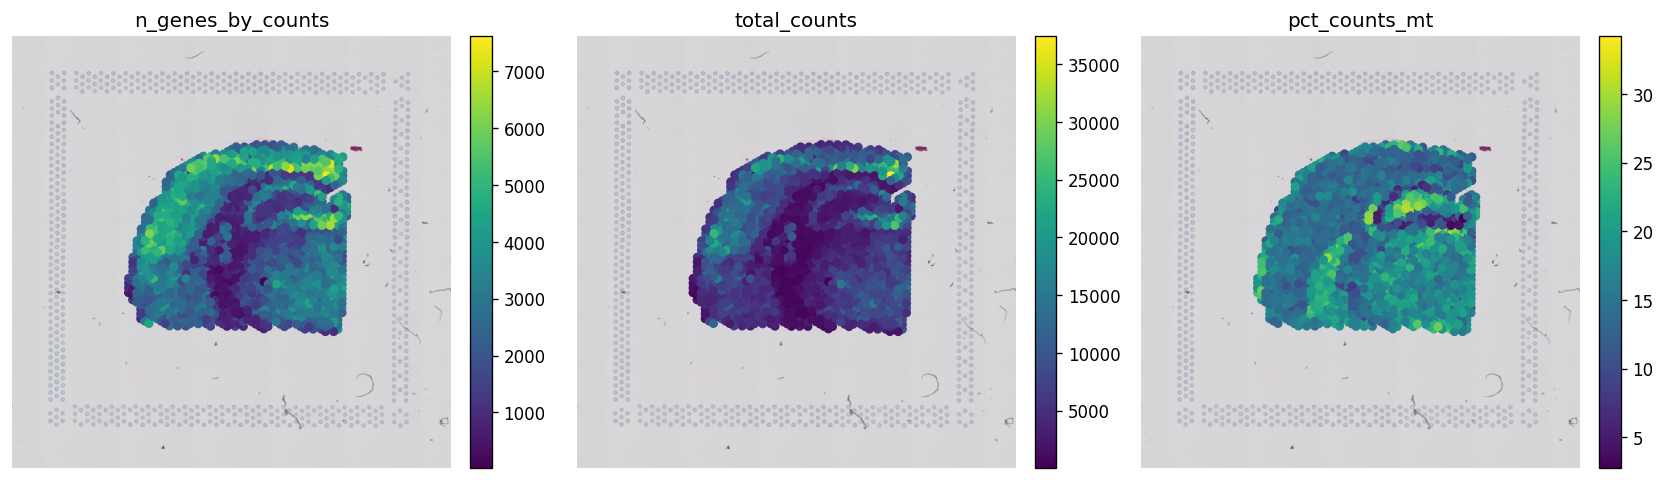

In [20]:
# Overlay manuel en lowres (points + image HE)
import numpy as np
import matplotlib.pyplot as plt

lib = list(ad.uns["spatial"].keys())[0]
sf  = ad.uns["spatial"][lib]["scalefactors"]["tissue_lowres_scalef"]
img = ad.uns["spatial"][lib]["images"]["lowres"]

xy_low = ad.obsm["spatial"] * sf
x, y = xy_low[:, 0], xy_low[:, 1]

H, W = img.shape[:2]
fig, axs = plt.subplots(1, 3, figsize=(14, 4))
for ax, col in zip(axs, ["n_genes_by_counts", "total_counts", "pct_counts_mt"]):
    ax.imshow(img)
    h = ax.scatter(x, y, c=ad.obs[col], s=20)  # augmente s si besoin
    ax.set_title(col)
    ax.set_xlim(0, W); ax.set_ylim(H, 0)      # IMPORTANT pour les coords d'image
    ax.set_axis_off()
    fig.colorbar(h, ax=ax, fraction=0.046, pad=0.04)
plt.tight_layout()


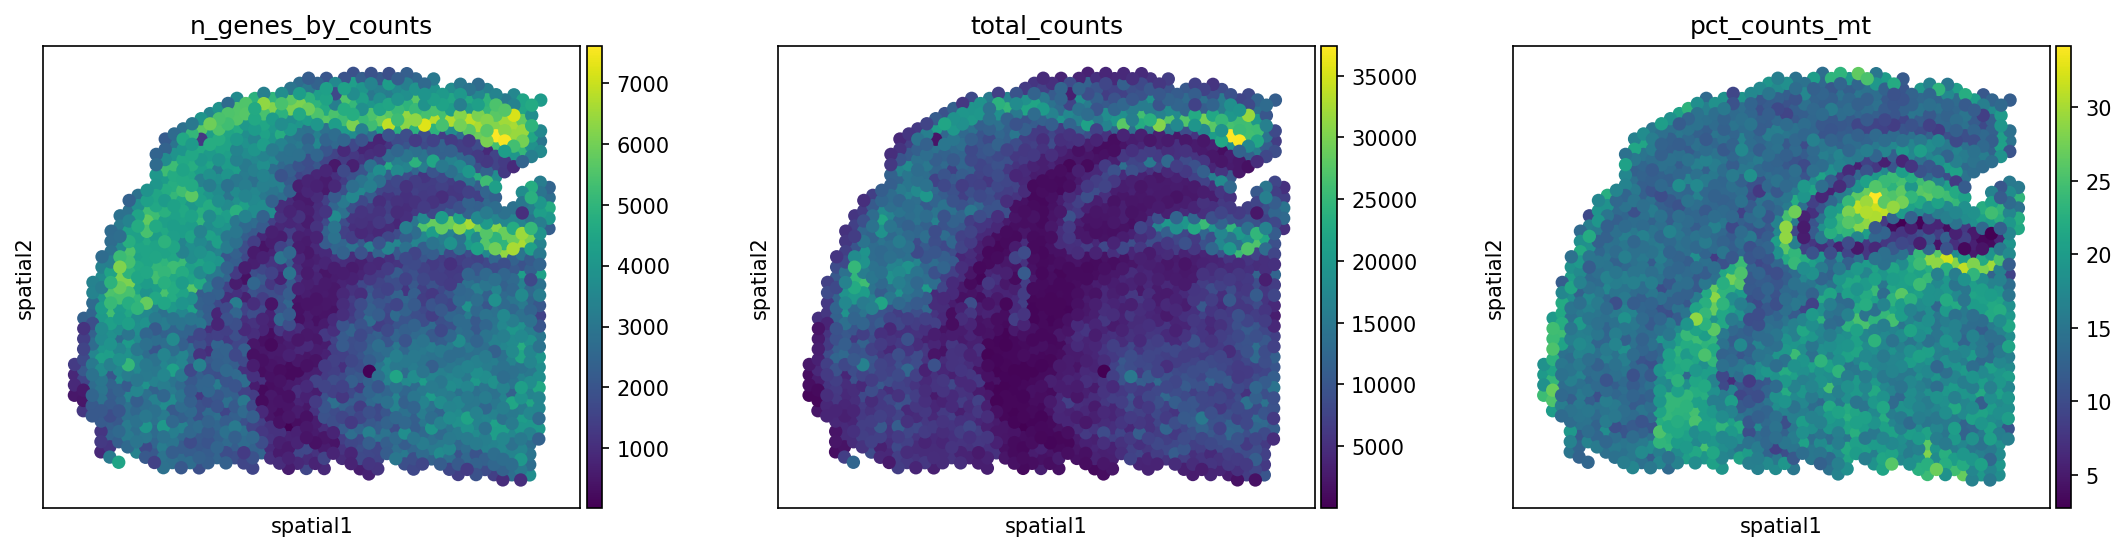

In [ ]:
lib = list(ad.uns["spatial"].keys())[0]
# Sans image, on peut garder les coords fullres et scale_factor=1.0
sq.pl.spatial_scatter(
    ad,
    library_id=lib,
    img=None,
    scale_factor=1.0,
    color=["n_genes_by_counts","total_counts","pct_counts_mt"],
    size=2.0,   # augmente si c’est petit (2–4)
    dpi=150
)


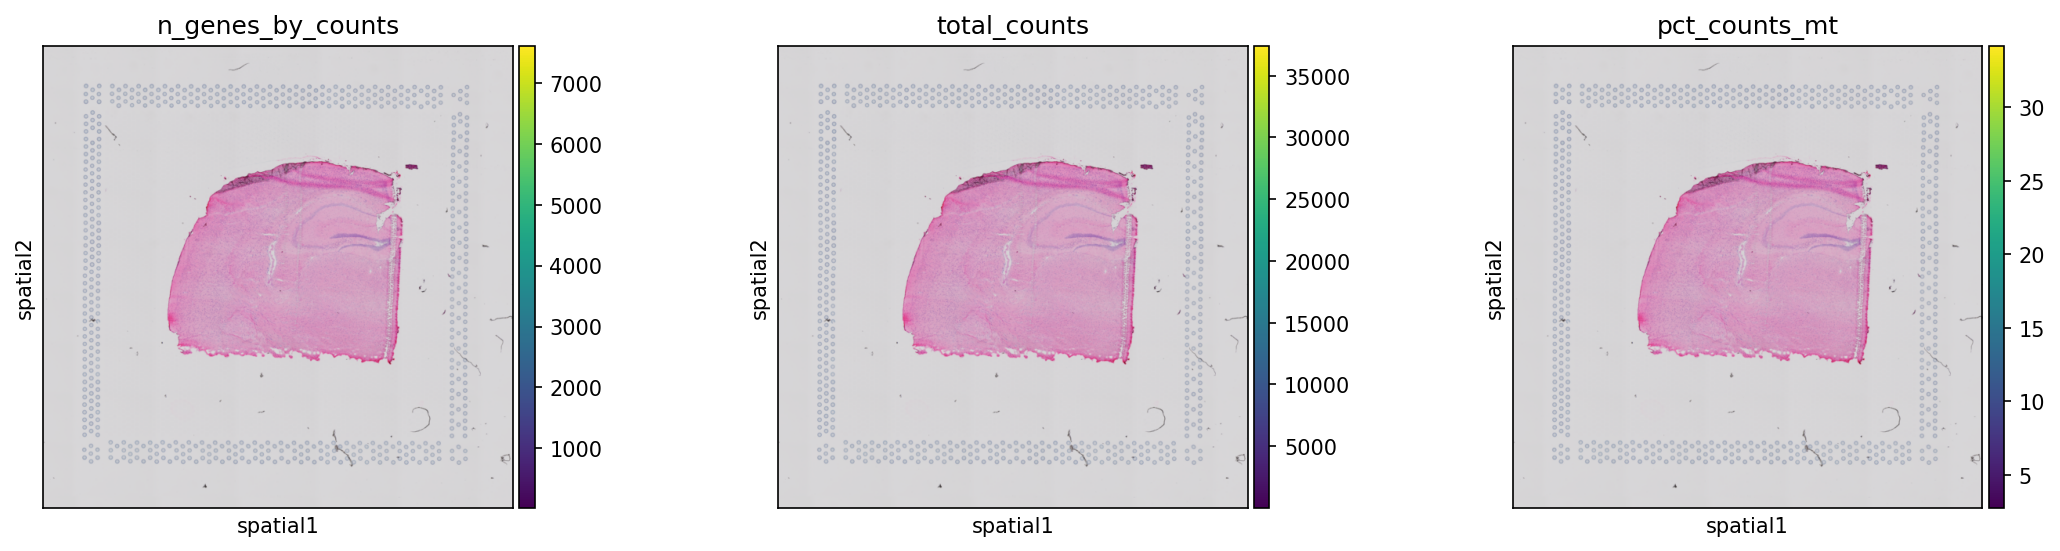

In [ ]:
lib = list(ad.uns["spatial"].keys())[0]
# Sans image, on peut garder les coords fullres et scale_factor=1.0
sq.pl.spatial_scatter(
    ad,
    library_id=lib,
    img=img,
    scale_factor=1.0,
    color=["n_genes_by_counts","total_counts","pct_counts_mt"],
    size=2.0,   # augmente si c’est petit (2–4)
    dpi=150
)


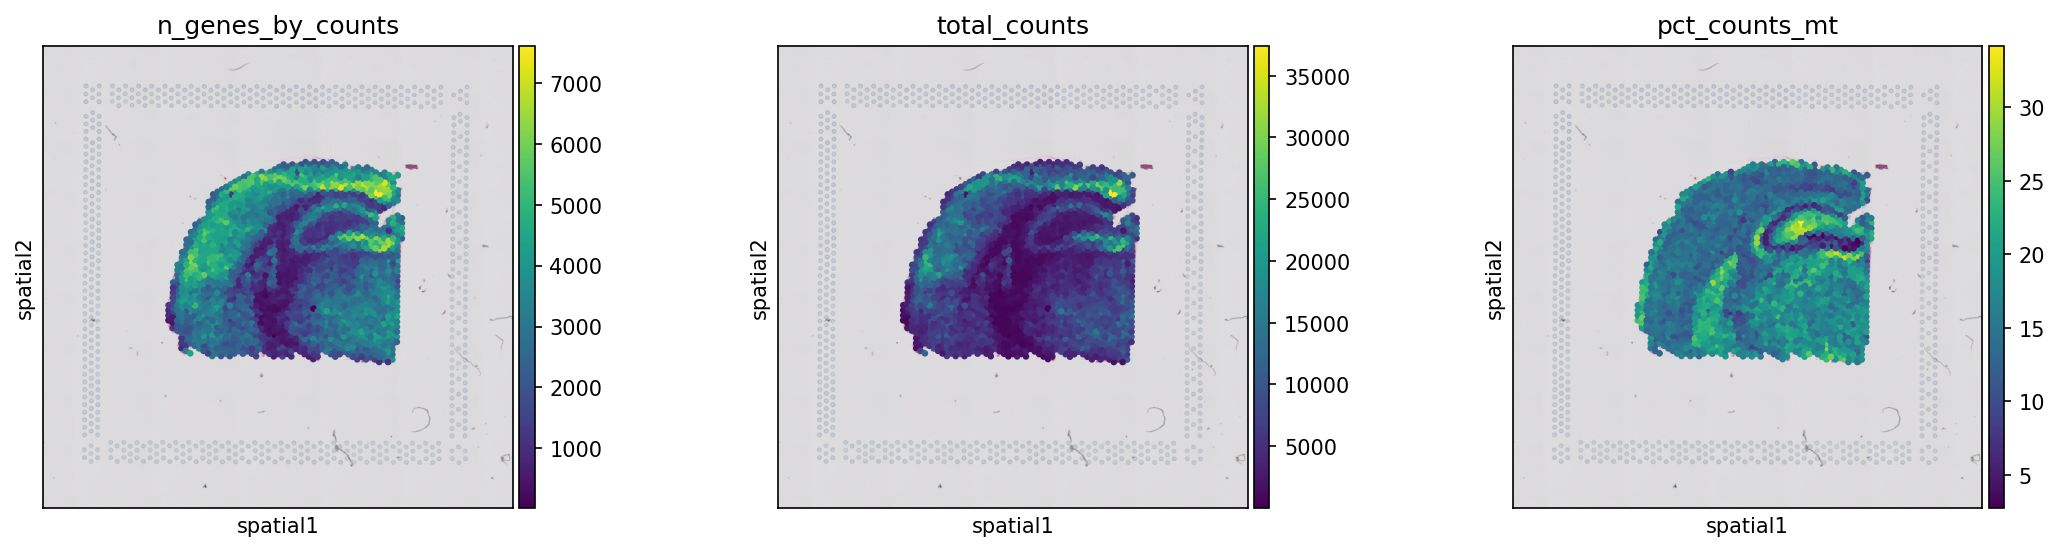

In [ ]:
lib = list(ad.uns["spatial"].keys())[0]
img = ad.uns["spatial"][lib]["images"]["lowres"]
sf  = ad.uns["spatial"][lib]["scalefactors"]["tissue_lowres_scalef"]  # <- CHANGE #1

sq.pl.spatial_scatter(
    ad,
    library_id=lib,
    img=img,
    scale_factor=sf,                 # <- CHANGE #2 (met le facteur lowres)
    color=["n_genes_by_counts","total_counts","pct_counts_mt"],
    size=2.0,
    dpi=150,
    img_alpha=0.85                   # (optionnel) rend l’image un peu transparente
)


## Étape 4 — QC visuel (cartes) et QC quantitatif (histos)
**Cartes** : `n_genes_by_counts`, `total_counts`, `pct_counts_mt` pour repérer des zones faibles / artefacts / ruptures.
**Histos** + percentiles : pour voir la distribution des spots par métrique.

**Règle générale Visium :**
- `n_genes` trop bas → spots peu informatifs,
- `total_counts` très bas → faible capture,
- `%MT` trop haut → qualité suspecte.

**Important :** pas de seuil universel → on choisit des **seuils adaptés aux lames**.


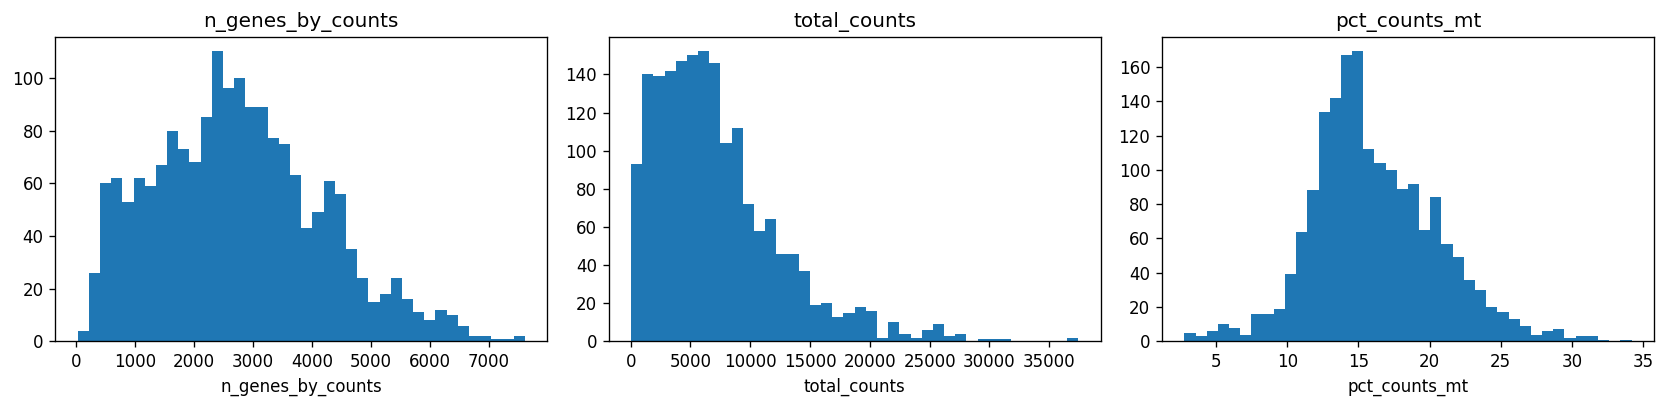

      n_genes_by_counts  total_counts  pct_counts_mt
0.01             343.72        511.88       5.592380
0.05             594.30        955.25       9.935832
0.10             876.60       1495.00      11.328665
0.90            4614.10      14103.20      21.952372
0.95            5387.70      17926.65      23.780093
0.99            6375.35      25538.20      28.527686


In [30]:
metrics = ["n_genes_by_counts", "total_counts", "pct_counts_mt"]

# 1) Histogrammes
fig, axs = plt.subplots(1, 3, figsize=(14, 3.5))
for ax, m in zip(axs, metrics):
    ax.hist(ad.obs[m], bins=40)
    ax.set_title(m)
    ax.set_xlabel(m)
plt.tight_layout()
plt.show()

# 2) Percentiles utiles pour guider les seuils
q = ad.obs[metrics].quantile([0.01, 0.05, 0.10, 0.90, 0.95, 0.99])
print(q)

In [31]:
# Étape 9 — Filtrage QC (simple et propre)
min_genes = 600
min_counts = 1500
max_mt    = 25.0

before = ad.n_obs
mask = (
    (ad.obs["in_tissue"] == 1)
    & (ad.obs["n_genes_by_counts"] >= min_genes)
    & (ad.obs["total_counts"]     >= min_counts)
    & (ad.obs["pct_counts_mt"]    <= max_mt)
)
ad_qc = ad[mask].copy()
print(f"Spots: {before} -> {ad_qc.n_obs} après filtres")

# petit résumé
ad_qc.obs[["n_genes_by_counts","total_counts","pct_counts_mt"]].describe()


Spots: 1794 -> 1555 après filtres


n_genes_by_counts  total_counts  pct_counts_mt
count        1555.000000   1555.000000    1555.000000
mean         3055.775563   8111.999512      15.823769
std          1278.638050   5175.754395       4.007254
min           828.000000   1502.000000       2.772486
25%          2130.000000   4455.500000      13.158613
50%          2903.000000   6863.000000      15.434273
75%          3840.500000  10402.500000      18.718304
max          7614.000000  37431.000000      24.905447

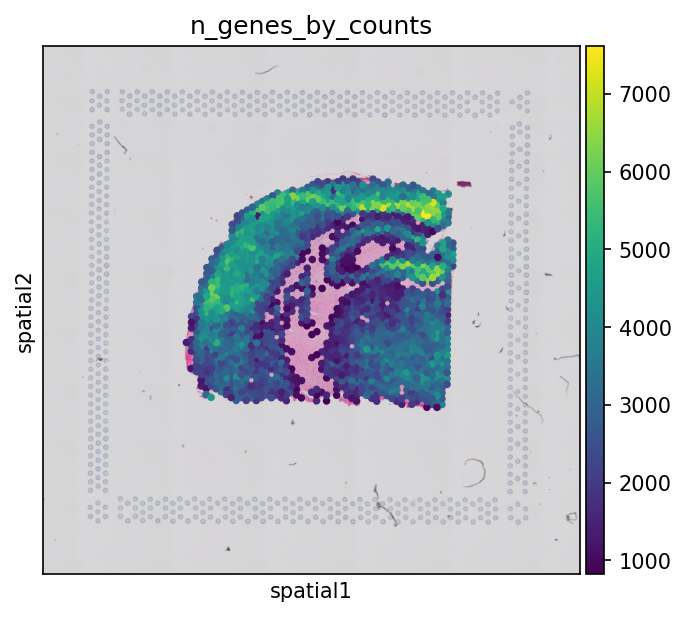

In [32]:
lib = list(ad_qc.uns["spatial"].keys())[0]
img = ad_qc.uns["spatial"][lib]["images"]["lowres"]
sf  = ad_qc.uns["spatial"][lib]["scalefactors"]["tissue_lowres_scalef"]

sq.pl.spatial_scatter(ad_qc, library_id=lib, img=img, scale_factor=sf,
                      color=["n_genes_by_counts"], size=2.0, dpi=150)


In [34]:
# ÉTAPE 11 — Charger + QC-filtrer TOUS les samples, même pipeline

import json
import matplotlib.pyplot as plt
import pandas as pd
from pathlib import Path
import scanpy as sc

min_genes = 600
min_counts = 1500
max_mt    = 25.0

def load_one_with_spatial(row):
    sdir = Path(row["sample_path"]).resolve()
    counts_dir = sdir / "filtered_feature_bc_matrix"
    ad = sc.read_10x_mtx(counts_dir, var_names="gene_symbols", cache=False)
    ad.var_names_make_unique()

    # annotations
    for k in ["gsm","sample_name","condition","replicate","section"]:
        v = row.get(k, None)
        if pd.notna(v):
            ad.obs[k] = str(v)

    # QC metrics
    mt_mask = ad.var_names.str.upper().str.startswith("MT-") | ad.var_names.str.lower().str.startswith("mt-")
    ad.var["mt"] = mt_mask
    sc.pp.calculate_qc_metrics(ad, qc_vars=["mt"], inplace=True)

    # attach spatial (positions + images + scalefactors)
    spdir = sdir / "spatial"
    pos = pd.read_csv(
        spdir / "tissue_positions_list.csv",
        header=None,
        names=["barcode","in_tissue","array_row","array_col","pxl_row_in_fullres","pxl_col_in_fullres"],
    ).set_index("barcode")
    pos = pos.loc[pos.index.intersection(ad.obs_names)]
    pos = pos[pos["in_tissue"] == 1]
    pos = pos.reindex(ad.obs_names)
    ad.obs["in_tissue"] = pos["in_tissue"]
    ad.obsm["spatial"] = pos[["pxl_col_in_fullres","pxl_row_in_fullres"]].to_numpy()

    with open(spdir / "scalefactors_json.json") as f:
        sf = json.load(f)
    img_hires  = plt.imread(spdir / "tissue_hires_image.png")
    img_lowres = plt.imread(spdir / "tissue_lowres_image.png")
    lib = sdir.name
    ad.uns.setdefault("spatial", {})
    ad.uns["spatial"][lib] = {
        "images": {"hires": img_hires, "lowres": img_lowres},
        "scalefactors": {
            "tissue_hires_scalef": float(sf["tissue_hires_scalef"]),
            "tissue_lowres_scalef": float(sf["tissue_lowres_scalef"]),
            "spot_diameter_fullres": float(sf["spot_diameter_fullres"]),
        },
        "metadata": {"source_image_path": str(spdir)},
    }

    # filtres QC
    mask = (
        (ad.obs["in_tissue"] == 1)
        & (ad.obs["n_genes_by_counts"] >= min_genes)
        & (ad.obs["total_counts"]     >= min_counts)
        & (ad.obs["pct_counts_mt"]    <= max_mt)
    )
    ad_qc = ad[mask].copy()
    return ad, ad_qc

ads, ads_qc, rows = {}, {}, []
for _, r in annot.iterrows():
    sname = r["sample_name"]
    ad_i, ad_qc_i = load_one_with_spatial(r)
    ads[sname] = ad_i
    ads_qc[sname] = ad_qc_i
    rows.append({
        "sample_name": sname,
        "condition": r["condition"],
        "replicate": r["replicate"],
        "section": r["section"],
        "spots_raw": ad_i.n_obs,
        "spots_qc": ad_qc_i.n_obs,
        "median_genes_qc": float(ad_qc_i.obs["n_genes_by_counts"].median()),
        "median_counts_qc": float(ad_qc_i.obs["total_counts"].median()),
    })

summary = pd.DataFrame(rows).sort_values(["condition","replicate","section","sample_name"])
summary


sample_name condition   replicate   section  spots_raw  spots_qc  \
0   Sample_3792-FM-S2-A     5XFAD  replicate1  section1       2380      2223   
1   Sample_3792-FM-S2-B     5XFAD  replicate1  section2       2171      2085   
2   Sample_3792-FM-S5-A     5XFAD  replicate2  section1       2345      2259   
3   Sample_3792-FM-S5-B     5XFAD  replicate2  section3       2287      2154   
4   Sample_3792-FM-S3-A   Vehicle  replicate1  section1       2484      2338   
5   Sample_3792-FM-S3-B   Vehicle  replicate1  section2       2732      2553   
6   Sample_3792-FM-S2-C        WT  replicate1  section1       1794      1555   
7   Sample_3792-FM-S2-D        WT  replicate1  section2       2410      2058   
8   Sample_3792-FM-S3-C      hNSC  replicate1  section1       2936      2751   
9   Sample_3792-FM-S3-D      hNSC  replicate1  section2       2459      2268   
10  Sample_3792-FM-S4-A      hNSC  replicate2  section1       1661        81   
11  Sample_3792-FM-S4-B      hNSC  replicate2  section2       1854       300   
12  Sample_3792-FM-S4-C      hNSC  replicate3  section1       1723       192   
13  Sample_3792-FM-S4-D      hNSC  replicate3  section2       1513       382   

    median_genes_qc  median_counts_qc  
0            3047.0            6432.0  
1            3349.0            7544.0  
2            4295.0           11961.0  
3            3898.0           10392.5  
4            2604.5            5559.5  
5            2435.0            5116.0  
6            2903.0            6863.0  
7            2696.5            6248.0  
8            2647.0            5938.0  
9            2736.0            6262.5  
10           1139.0            1756.0  
11           1171.5            1780.5  
12           1151.0            1800.5  
13           1198.0            1872.0

## Étape 5 — QC adaptatif par sample
On conserve, **pour chaque sample**, les spots au-dessus du **10e centile** de `n_genes` **et** de `total_counts`, avec un plancher doux (≥300 gènes, ≥800 UMIs) et `%MT ≤ 30`.

**Pourquoi ce choix :**
- la qualité varie entre coupes (tissu, coupe, slide),
- un seuil global fixe tuerait certaines lames (p. ex. hNSC rep2/rep3),
- c’est cohérent avec les pratiques : le papier s’appuie surtout sur intégration/statistiques plutôt que des cutoffs durs spot-level.

**Résultat attendu :**
- nombre de spots retenus plus homogène entre samples,
- conservation d’un **signal biologique** suffisant pour l’intégration.


In [35]:
# DIAG — Qu'est-ce qui fait chuter les spots ? (par sample)
min_genes = 600
min_counts = 1500
max_mt    = 25.0

rows = []
for sname, ad_i in ads.items():  # 'ads' = bruts, avant QC, construit à l'étape 11
    n = ad_i.n_obs
    in_tissue = (ad_i.obs.get("in_tissue", 1) == 1).fillna(False)

    fail_genes  = (ad_i.obs["n_genes_by_counts"] < min_genes)
    fail_counts = (ad_i.obs["total_counts"]     < min_counts)
    fail_mt     = (ad_i.obs["pct_counts_mt"]    > max_mt)

    keep = in_tissue & ~fail_genes & ~fail_counts & ~fail_mt

    rows.append({
        "sample_name": sname,
        "condition": ad_i.obs["condition"][0] if "condition" in ad_i.obs else None,
        "replicate": ad_i.obs["replicate"][0] if "replicate" in ad_i.obs else None,
        "section":   ad_i.obs["section"][0]   if "section"   in ad_i.obs else None,
        "spots_raw": n,
        "drop_not_in_tissue": int((~in_tissue).sum()),
        "drop_genes": int((~in_tissue & fail_genes).sum() + (in_tissue & fail_genes).sum()),   # combien sous min_genes
        "drop_counts": int((in_tissue & fail_counts).sum()),                                    # combien sous min_counts
        "drop_mt": int((in_tissue & fail_mt).sum()),                                            # combien au-dessus max_mt
        "kept": int(keep.sum()),
    })

diag = pd.DataFrame(rows).sort_values(["condition","replicate","section","sample_name"])
diag


/tmp/ipykernel_3533238/1203549792.py:19: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  "condition": ad_i.obs["condition"][0] if "condition" in ad_i.obs else None,
/tmp/ipykernel_3533238/1203549792.py:20: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  "replicate": ad_i.obs["replicate"][0] if "replicate" in ad_i.obs else None,
/tmp/ipykernel_3533238/1203549792.py:21: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  "section":   ad_i.obs["

sample_name condition   replicate   section  spots_raw  \
0   Sample_3792-FM-S2-A     5XFAD  replicate1  section1       2380   
1   Sample_3792-FM-S2-B     5XFAD  replicate1  section2       2171   
2   Sample_3792-FM-S5-A     5XFAD  replicate2  section1       2345   
3   Sample_3792-FM-S5-B     5XFAD  replicate2  section3       2287   
4   Sample_3792-FM-S3-A   Vehicle  replicate1  section1       2484   
5   Sample_3792-FM-S3-B   Vehicle  replicate1  section2       2732   
6   Sample_3792-FM-S2-C        WT  replicate1  section1       1794   
7   Sample_3792-FM-S2-D        WT  replicate1  section2       2410   
8   Sample_3792-FM-S3-C      hNSC  replicate1  section1       2936   
9   Sample_3792-FM-S3-D      hNSC  replicate1  section2       2459   
10  Sample_3792-FM-S4-A      hNSC  replicate2  section1       1661   
11  Sample_3792-FM-S4-B      hNSC  replicate2  section2       1854   
12  Sample_3792-FM-S4-C      hNSC  replicate3  section1       1723   
13  Sample_3792-FM-S4-D      hNSC  replicate3  section2       1513   

    drop_not_in_tissue  drop_genes  drop_counts  drop_mt  kept  
0                    0          47          138       25  2223  
1                    0          34           79        9  2085  
2                    0          40           82        4  2259  
3                    0          52          113       21  2154  
4                    0          37          136       10  2338  
5                    0          28          175        7  2553  
6                    0          93          181       62  1555  
7                    0          73          170      199  2058  
8                    0          39          152       34  2751  
9                    0          72          113       78  2268  
10                   0        1113         1580        6    81  
11                   0         828         1554        5   300  
12                   0        1047         1529       56   192  
13                   0         660         1130       41   382

## Étape 6 — Charger tous les samples, attacher `spatial`, appliquer le QC adaptatif
On boucle sur **tous** les `Sample_*` :
1) chargement MTX + annotations (`condition/replicate/section/gsm`),
2) attache `spatial` (positions + images + scalefactors),
3) calcul des métriques QC,
4) application des seuils **adaptatifs**,
5) tableau récapitulatif (spots bruts vs spots retenus).

**Pourquoi :** on standardise le pipeline sur chaque coupe avant l’intégration globale.


In [ ]:
# QC ADAPTATIF (par sample) — simple
p = 0.10                 # 10e centile par sample
min_floor_genes = 300
min_floor_counts = 800
max_mt = 30.0

ads_qc = {}
rows = []

for sname, ad_i in ads.items():  # 'ads' = bruts avant QC
    g_thr = max(min_floor_genes, float(ad_i.obs["n_genes_by_counts"].quantile(p)))
    c_thr = max(min_floor_counts, float(ad_i.obs["total_counts"].quantile(p)))
    m_thr = max_mt

    mask = (
        (ad_i.obs.get("in_tissue", 1) == 1)
        & (ad_i.obs["n_genes_by_counts"] >= g_thr)
        & (ad_i.obs["total_counts"]     >= c_thr)
        & (ad_i.obs["pct_counts_mt"]    <= m_thr)
    )
    ad_qc_i = ad_i[mask].copy()
    ads_qc[sname] = ad_qc_i

    rows.append({
        "sample_name": sname,
        "condition": ad_i.obs["condition"][0],
        "replicate": ad_i.obs["replicate"][0],
        "section":   ad_i.obs["section"][0],
        "spots_raw": ad_i.n_obs,
        "g_thr": int(g_thr),
        "c_thr": int(c_thr),
        "mt_thr": m_thr,
        "spots_qc": ad_qc_i.n_obs,
        "median_genes_qc": float(ad_qc_i.obs["n_genes_by_counts"].median()),
        "median_counts_qc": float(ad_qc_i.obs["total_counts"].median()),
    })

summary_adapt = pd.DataFrame(rows).sort_values(["condition","replicate","section","sample_name"])
summary_adapt


/tmp/ipykernel_3533238/560138623.py:28: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  "condition": ad_i.obs["condition"][0],
/tmp/ipykernel_3533238/560138623.py:29: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  "replicate": ad_i.obs["replicate"][0],
/tmp/ipykernel_3533238/560138623.py:30: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  "section":   ad_i.obs["section"][0],
/tmp/ipykernel_3533238/560138623.py:28: FutureWarning: Series._

sample_name condition   replicate   section  spots_raw  g_thr  \
0   Sample_3792-FM-S2-A     5XFAD  replicate1  section1       2380   1233   
1   Sample_3792-FM-S2-B     5XFAD  replicate1  section2       2171   1482   
2   Sample_3792-FM-S5-A     5XFAD  replicate2  section1       2345   1737   
3   Sample_3792-FM-S5-B     5XFAD  replicate2  section3       2287   1625   
4   Sample_3792-FM-S3-A   Vehicle  replicate1  section1       2484   1138   
5   Sample_3792-FM-S3-B   Vehicle  replicate1  section2       2732   1024   
6   Sample_3792-FM-S2-C        WT  replicate1  section1       1794    876   
7   Sample_3792-FM-S2-D        WT  replicate1  section2       2410    957   
8   Sample_3792-FM-S3-C      hNSC  replicate1  section1       2936   1135   
9   Sample_3792-FM-S3-D      hNSC  replicate1  section2       2459   1258   
10  Sample_3792-FM-S4-A      hNSC  replicate2  section1       1661    300   
11  Sample_3792-FM-S4-B      hNSC  replicate2  section2       1854    300   
12  Sample_3792-FM-S4-C      hNSC  replicate3  section1       1723    300   
13  Sample_3792-FM-S4-D      hNSC  replicate3  section2       1513    300   

    c_thr  mt_thr  spots_qc  median_genes_qc  median_counts_qc  
0    1996    30.0      2124           3123.5            6707.0  
1    2539    30.0      1943           3466.0            7942.0  
2    3261    30.0      2092           4439.0           12609.5  
3    3138    30.0      2046           4004.0           10786.0  
4    1938    30.0      2219           2705.0            5831.0  
5    1752    30.0      2441           2495.0            5267.0  
6    1495    30.0      1602           2852.5            6729.0  
7    1746    30.0      2107           2683.0            6236.0  
8    2066    30.0      2616           2756.0            6244.0  
9    2345    30.0      2177           2797.0            6497.0  
10    800    30.0       594            761.5            1071.5  
11    800    30.0      1059            849.0            1217.0  
12    800    30.0       737            809.0            1166.0  
13    800    30.0       932            927.0            1371.5

## Étape 7 — Concat globale + intégration “light”
On concatène les objets post-QC en ajoutant `concat_batch` (clé de batch = `condition_replicate_section_sample`).

Pipeline :
- `normalize_total` → `log1p`,
- **HVGs = 3 000** (avec `batch_key='concat_batch'`),
- `scale` → `PCA` (50 comps) → graph voisins → **UMAP** → **Leiden**.

**Pourquoi :**
- sélection HVGs par batch ≈ comportement d’une intégration “ancrée”,
- UMAP/Leiden donnent une vue globale en contrôlant un minimum l’effet diapo/section.


In [39]:
!pip install scikit-misc

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 189.0/189.0 kB 4.2 MB/s eta 0:00:0000:01


In [ ]:
# ÉTAPE 7 — Concat globale (post-QC) + intégration light + UMAP/Leiden

import numpy as np
import scanpy as sc

# 1) Ordre lisible des samples
order = (
    annot.sort_values(["condition","replicate","section","sample_name"])
         ["sample_name"].tolist()
)

ad_list, batch_names = [], []
for sname in order:
    if sname not in ads_qc:
        continue
    A = ads_qc[sname]  # objet post-QC pour ce sample
    ad_list.append(A)
    cond = A.obs["condition"][0] if "condition" in A.obs else "NA"
    rep  = A.obs["replicate"][0] if "replicate" in A.obs else "NA"
    sec  = A.obs["section"][0]   if "section"   in A.obs else "NA"
    batch_names.append(f"{cond}_{rep}_{sec}_{sname}")

assert len(ad_list) > 0, "Aucun objet post-QC à concaténer."

# 2) Concat
adata = ad_list[0].concatenate(
    ad_list[1:], 
    batch_key="concat_batch",
    batch_categories=batch_names
)

# 3) Nettoyage des colonnes
for col in ["condition","replicate","section","sample_name"]:
    if col in adata.obs:
        adata.obs[col] = adata.obs[col].astype(str)


/tmp/ipykernel_3533238/971481721.py:18: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  cond = A.obs["condition"][0] if "condition" in A.obs else "NA"
/tmp/ipykernel_3533238/971481721.py:19: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  rep  = A.obs["replicate"][0] if "replicate" in A.obs else "NA"
/tmp/ipykernel_3533238/971481721.py:20: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  sec  = A.obs["section"][0]   if "section"   in A.obs

In [42]:
# Normalisation & log
sc.pp.normalize_total(adata, target_sum=1e4)
sc.pp.log1p(adata)

# HVGs par batch (clé = concat_batch), méthode seurat_v3
sc.pp.highly_variable_genes(
    adata,
    flavor="seurat_v3",
    n_top_genes=3000,
    batch_key="concat_batch"
)

print("HVGs retenus :", int(adata.var['highly_variable'].sum()))
adata.var.loc[adata.var['highly_variable']].head()

normalizing counts per cell
    finished (0:00:00)
extracting highly variable genes


/data/home/aboussif/venv/lib/python3.11/site-packages/scanpy/preprocessing/_highly_variable_genes.py:74: UserWarning: `flavor='seurat_v3'` expects raw count data, but non-integers were found.
  warnings.warn(


HVGs retenus : 3000


gene_ids    feature_types     mt  \
Vxn      ENSMUSG00000067879  Gene Expression  False   
Eya1     ENSMUSG00000025932  Gene Expression  False   
Sbspon   ENSMUSG00000032719  Gene Expression  False   
Rdh10    ENSMUSG00000025921  Gene Expression  False   
Gm15825  ENSMUSG00000089787  Gene Expression  False   

         n_cells_by_counts-5XFAD_replicate1_section1_Sample_3792-FM-S2-A  \
Vxn                                                   1053                 
Eya1                                                    93                 
Sbspon                                                  11                 
Rdh10                                                  196                 
Gm15825                                                  2                 

         mean_counts-5XFAD_replicate1_section1_Sample_3792-FM-S2-A  \
Vxn                                               2.028992           
Eya1                                              0.041597           
Sbspon                                            0.005462           
Rdh10                                             0.094538           
Gm15825                                           0.000840           

         log1p_mean_counts-5XFAD_replicate1_section1_Sample_3792-FM-S2-A  \
Vxn                                               1.108230                 
Eya1                                              0.040755                 
Sbspon                                            0.005447                 
Rdh10                                             0.090332                 
Gm15825                                           0.000840                 

         pct_dropout_by_counts-5XFAD_replicate1_section1_Sample_3792-FM-S2-A  \
Vxn                                              55.756303                     
Eya1                                             96.092437                     
Sbspon                                           99.537815                     
Rdh10                                            91.764706                     
Gm15825                                          99.915966                     

         total_counts-5XFAD_replicate1_section1_Sample_3792-FM-S2-A  \
Vxn                                                 4829.0            
Eya1                                                  99.0            
Sbspon                                                13.0            
Rdh10                                                225.0            
Gm15825                                                2.0            

         log1p_total_counts-5XFAD_replicate1_section1_Sample_3792-FM-S2-A  \
Vxn                                               8.482602                  
Eya1                                              4.605170                  
Sbspon                                            2.639057                  
Rdh10                                             5.420535                  
Gm15825                                           1.098612                  

         n_cells_by_counts-5XFAD_replicate1_section2_Sample_3792-FM-S2-B  ...  \
Vxn                                                   1027                ...   
Eya1                                                   105                ...   
Sbspon                                                  18                ...   
Rdh10                                                  199                ...   
Gm15825                                                  3                ...   

         log1p_mean_counts-hNSC_replicate3_section2_Sample_3792-FM-S4-D  \
Vxn                                               0.257829                
Eya1                                              0.007900                
Sbspon                                            0.000000                
Rdh10                                             0.012480                
Gm15825                                           0.000661                

         pct_dropout_by_counts-hNSC_replicat

... as `zero_center=True`, sparse input is densified and may lead to large memory consumption
computing PCA
    with n_comps=50
    finished (0:00:12)


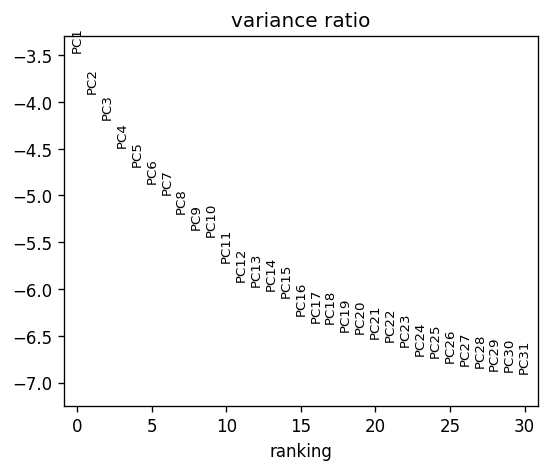

In [43]:
# ÉTAPE 8 — PCA + visualisation variance
# 1) garder une copie "raw" avant de sous-échantillonner les gènes
adata.raw = adata

# 2) ne garder que les gènes hautement variables (HVGs)
adata = adata[:, adata.var["highly_variable"]].copy()

# 3) scale + PCA
sc.pp.scale(adata, max_value=10)
sc.tl.pca(adata, n_comps=50, svd_solver="arpack")

# petit check visuel
sc.pl.pca_variance_ratio(adata, log=True)


In [45]:
import sys, subprocess, importlib
try:
    importlib.import_module("leidenalg")
    print("leidenalg déjà installé.")
except ImportError:
    print("Installation de leidenalg…")
    subprocess.check_call([sys.executable, "-m", "pip", "install", "-q", "leidenalg"])
    print("OK.")


Installation de leidenalg…
OK.


In [46]:
# Graphes de voisinage (sur la PCA calculée juste avant)
sc.pp.neighbors(adata, n_neighbors=20, n_pcs=30)

computing neighbors
    using 'X_pca' with n_pcs = 30
    finished (0:00:06)


running Leiden clustering


/tmp/ipykernel_3533238/2487873014.py:1: FutureWarning: In the future, the default backend for leiden will be igraph instead of leidenalg.

 To achieve the future defaults please pass: flavor="igraph" and n_iterations=2.  directed must also be False to work with igraph's implementation.
  sc.tl.leiden(adata, resolution=0.8)


    finished (0:00:23)


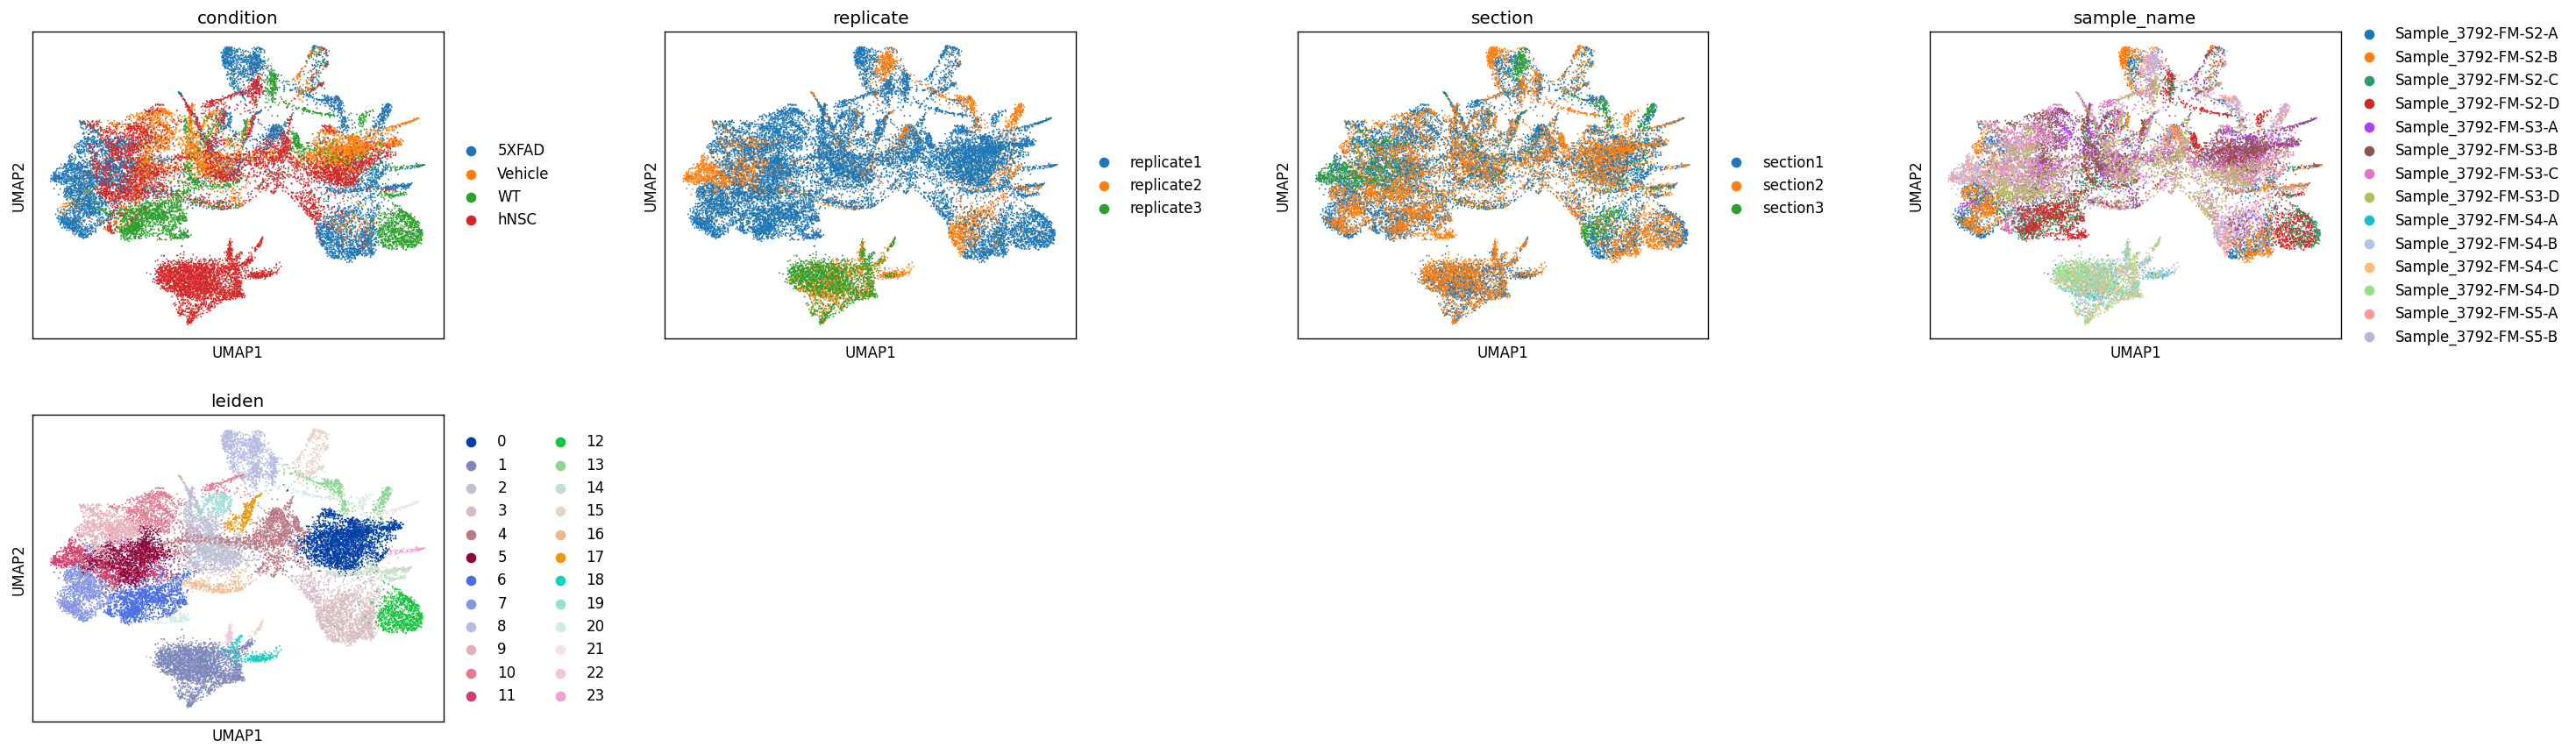

In [47]:
sc.tl.leiden(adata, resolution=0.8)
sc.pl.umap(adata, color=["condition","replicate","section","sample_name","leiden"], wspace=0.4)


In [49]:
# Étape A — extraire slide_id (S2/S3/...) et capture_area (A/B/C/D) depuis sample_name
import re

def parse_sample_name(s):
    m = re.search(r"-S(\d+)-([A-D])$", str(s))
    if m:
        return f"S{m.group(1)}", m.group(2)
    return None, None

slides, areas = [], []
for s in adata.obs["sample_name"].astype(str):
    sl, ar = parse_sample_name(s)
    slides.append(sl); areas.append(ar)

adata.obs["slide_id"] = slides
adata.obs["capture_area"] = areas

adata.obs[["sample_name","slide_id","capture_area"]].tail()


sample_name  \
TTGGTCACACTCGTAA-1-hNSC_replicate3_section2_Sam...  Sample_3792-FM-S4-D   
TTGTAATCCGTACTCG-1-hNSC_replicate3_section2_Sam...  Sample_3792-FM-S4-D   
TTGTGAACCTAATCCG-1-hNSC_replicate3_section2_Sam...  Sample_3792-FM-S4-D   
TTGTGGCCCTGACAGT-1-hNSC_replicate3_section2_Sam...  Sample_3792-FM-S4-D   
TTGTGTATGCCACCAA-1-hNSC_replicate3_section2_Sam...  Sample_3792-FM-S4-D   

                                                   slide_id capture_area  
TTGGTCACACTCGTAA-1-hNSC_replicate3_section2_Sam...       S4            D  
TTGTAATCCGTACTCG-1-hNSC_replicate3_section2_Sam...       S4            D  
TTGTGAACCTAATCCG-1-hNSC_replicate3_section2_Sam...       S4            D  
TTGTGGCCCTGACAGT-1-hNSC_replicate3_section2_Sam...       S4            D  
TTGTGTATGCCACCAA-1-hNSC_replicate3_section2_Sam...       S4            D

In [50]:
# Inventaire par zone: combien de spots et quelles conditions présentes
inv = (adata.obs.groupby(["capture_area","condition"])
       .size().rename("n_spots").reset_index())
display(inv)

# Résumé lisible
order = {"WT":0, "5XFAD":1, "Vehicle":2, "hNSC":3}
zones = sorted(adata.obs["capture_area"].dropna().unique())
for z in zones:
    conds = sorted(adata.obs.loc[adata.obs.capture_area==z, "condition"].unique(), key=lambda c: order.get(c, 99))
    print(f"Zone {z}: {', '.join(conds)}")


/tmp/ipykernel_3533238/774938414.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  inv = (adata.obs.groupby(["capture_area","condition"])


capture_area condition  n_spots
0             A     5XFAD     4216
1             A   Vehicle     2219
2             A        WT        0
3             A      hNSC      594
4             B     5XFAD     3989
5             B   Vehicle     2441
6             B        WT        0
7             B      hNSC     1059
8             C     5XFAD        0
9             C   Vehicle        0
10            C        WT     1602
11            C      hNSC     3353
12            D     5XFAD        0
13            D   Vehicle        0
14            D        WT     2107
15            D      hNSC     3109

Zone A: 5XFAD, Vehicle, hNSC
Zone B: 5XFAD, Vehicle, hNSC
Zone C: WT, hNSC
Zone D: WT, hNSC


computing PCA
    with n_comps=50


    finished (0:00:09)
computing neighbors
    using 'X_pca' with n_pcs = 30
    finished (0:00:00)
computing UMAP
    finished (0:00:19)


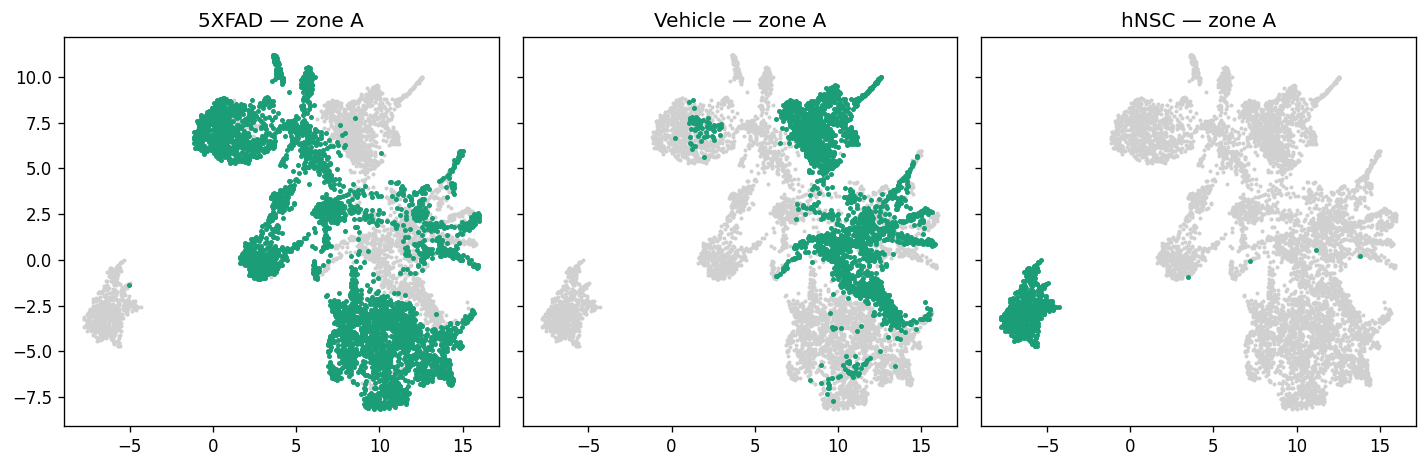

computing PCA
    with n_comps=50
    finished (0:00:09)
computing neighbors
    using 'X_pca' with n_pcs = 30
    finished (0:00:00)
computing UMAP
    finished (0:00:19)


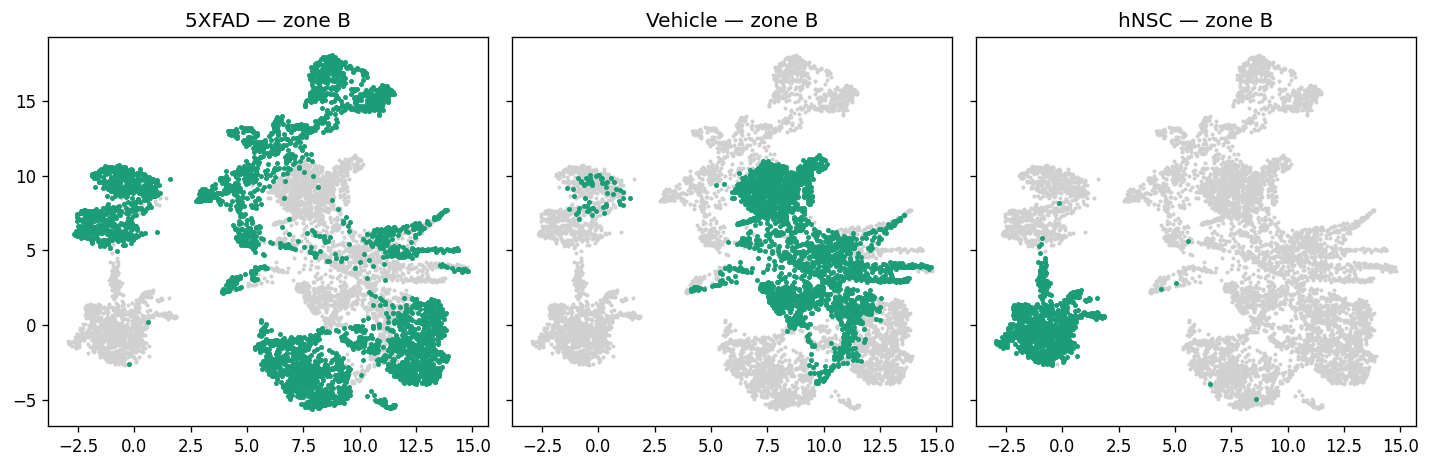

computing PCA
    with n_comps=50
    finished (0:00:09)
computing neighbors
    using 'X_pca' with n_pcs = 30
    finished (0:00:00)
computing UMAP
    finished (0:00:10)


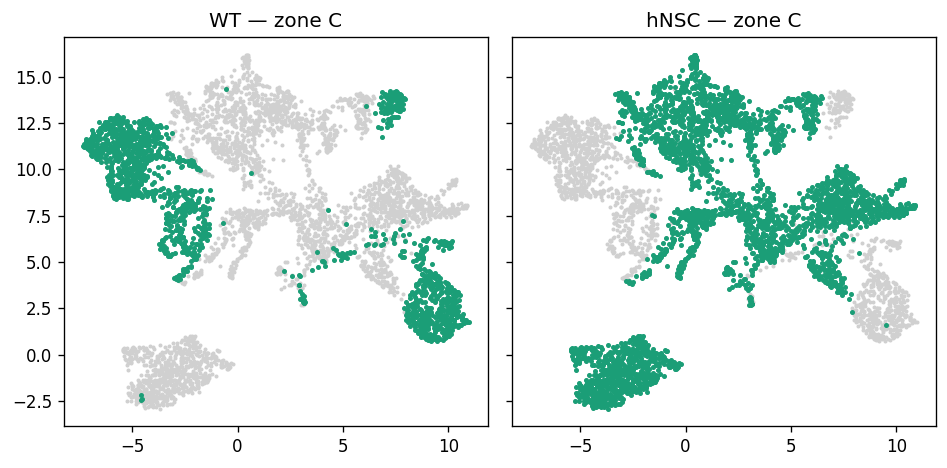

computing PCA
    with n_comps=50
    finished (0:00:09)
computing neighbors
    using 'X_pca' with n_pcs = 30
    finished (0:00:00)
computing UMAP
    finished (0:00:10)


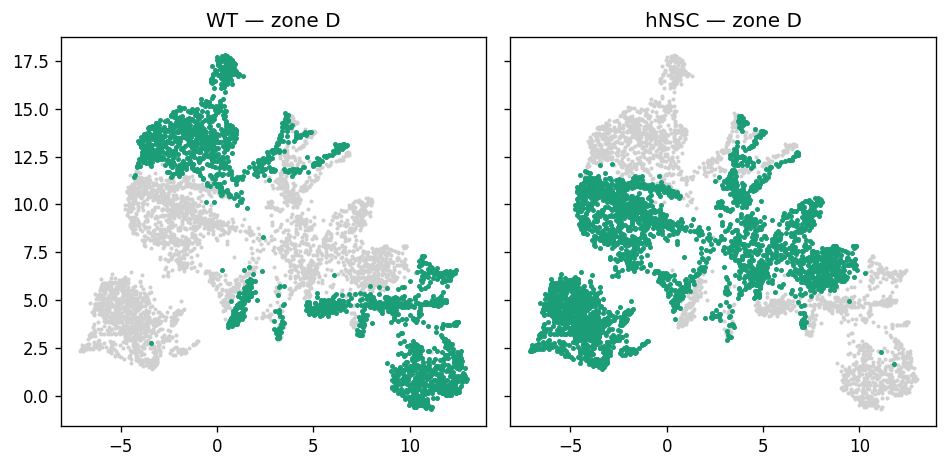

In [54]:
def plot_umap_highlight_by_condition_area(adata_full, area, cond_order=("WT","5XFAD","Vehicle","hNSC")):
    A = adata_full[adata_full.obs["capture_area"]==area].copy()
    if A.n_obs == 0:
        print(f"[Zone {area}] aucun spot, skip.")
        return

    # (Re)embedding sur la zone sélectionnée
    sc.tl.pca(A, n_comps=50, svd_solver="arpack")
    sc.pp.neighbors(A, n_neighbors=20, n_pcs=30)
    sc.tl.umap(A)

    present = [c for c in cond_order if c in list(A.obs["condition"].unique())]
    n = len(present)
    fig, axes = plt.subplots(1, n, figsize=(4*n, 4), sharex=True, sharey=True)
    if n == 1: axes = [axes]

    x = A.obsm["X_umap"][:,0]; y = A.obsm["X_umap"][:,1]
    for ax, cond in zip(axes, present):
        ax.scatter(x, y, s=2, c="#D0D0D0", rasterized=True)           # fond gris
        sel = (A.obs["condition"] == cond).values
        ax.scatter(x[sel], y[sel], s=4, c="#1b9e77", rasterized=True) # teal
        ax.set_title(f"{cond} — zone {area}")
    plt.tight_layout()
    plt.show()

# Lancer pour TOUTES les zones présentes
for z in sorted(adata.obs["capture_area"].dropna().unique()):
    plot_umap_highlight_by_condition_area(adata, z)


## Étape 8 — Interpréter UMAP/Leiden
- Colorier par `condition`, `replicate`, `section`, `sample_name` pour voir les structures,
- Vérifier que les clusters ne correspondent pas **uniquement** aux batches (sections/slides),
- Ajuster `n_neighbors`, `resolution` si trop/peu de clusters.

**But :** s’assurer que l’intégration “light” ne dénature pas la séparation biologique grossière et ne crée pas de clusters purement “techniques”.


## Étape 9 — Cartes de marqueurs par sample
Gènes utiles (souris) :
- **Microglie** : *Itgam, Cx3cr1, Trem2, Tyrobp, Aif1*  
- **DAM** : *Cst7, Lpl, Itgax, Spp1*  
- **Astrocytes** : *Gfap, Aqp4, Slc1a3*  
- **Oligodendrocytes** : *Mog, Mag, Olig1, Olig2*  
- **Neurones** : *Snap25, Rbfox3, Map2*

**Pourquoi :** relier les clusters/UMAP à l’espace et aux types cellulaires/réponses (ex. microglie activée/DAM proche de dépôts).


## Étape 10 — Sauvegardes
- Sauver chaque sample post-QC (`.h5ad`) + l’objet global concaténé,
- Sauver la table récap (spots bruts/QC, médianes),
- Versionner le notebook + `sample_sheet.csv`.

**Pourquoi :** reproductibilité, reprise facile (pas besoin de re-scanner/re-attacher `spatial`).


## Ce que je peux dire sur mon CV
- **Spatial transcriptomics (10x Visium), cerveau de souris (modèle 5XFAD Alzheimer)** :
  - pipeline complet : chargement MTX, attachement images/coords, QC **adaptatif par sample**,
  - intégration multi-sections (HVGs 3k), UMAP/Leiden,
  - cartes spatiales de marqueurs (microglie/DAM, astro, oligo, neurones).
- **Organisation des données** et **traçabilité** (sample_sheet, exports `.h5ad`/CSV).



### Notes & tips
- **Extraction**: if some samples are still `.tar.gz`, run `tar -xzvf file.tar.gz` so each `Sample_*` has `filtered_feature_bc_matrix/` and `spatial/`.
- **Gene names**: if features are Ensembl IDs, map to symbols before marker plots.
- **Regions**: for hippocampus‑only analyses, create a spatial mask and subset spots (can be added later).
- **Batch effects**: for deeper integration, consider `bbknn` or `scvi-tools`.


## Tips / pièges rencontrés
- **MTX vs H5** : en MTX, `sc.read_visium` peut pointer sur `.h5` → utiliser `sc.read_10x_mtx` + attacher `spatial` manuellement.
- **Squidpy** : pour overlay, toujours vérifier `scale_factor` (fullres → lowres) sinon points décalés/invisibles.
- **Chemins relatifs** : exécuter le notebook là où `DATA_ROOT` pointe (ou utiliser des chemins absolus depuis `annot`).
- **Images par-dessus les points** : si `img` est redessinée après, l’image couvre les spots → passer l’image avant ou `img_alpha`.


## Next steps (optionnels)
1) **Masque hippocampe** : définir un polygone (ou bounding box) sur l’image, sélectionner les spots in-polygon, refaire UMAP/DE sur cette région.
2) **Pseudo-bulk par section** : sommer les comptes par sample/section → DE plus robuste au niveau réplicat/condition.
3) **Annotation par signatures** : scores de types cellulaires (microglie/astro/oligo/neurones) et de modules (PIGs) pour interprétation fine.
